In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
import imageio
import cv2 
import os
from PIL import Image
from scipy import ndimage
from scipy import misc

/Users/horionorikadu/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [37]:
train_messy = "./messy-vs-clean-room/images/train/messy"
train_clean= "./messy-vs-clean-room/images/train/clean"
test_messy= "./messy-vs-clean-room/images/val/messy"
test_clean= "./messy-vs-clean-room/images/val/clean"

In [38]:
def load_dataset():
    
    train_set_x_orig_list,train_set_y_list, test_set_x_orig_list, test_set_y_list=[],[],[],[]
    for i,image in enumerate(os.listdir(train_messy)): 
        if image == ".DS_Store":
            continue
        path = os.path.join(train_messy, image)
        img = cv2.imread(path) 
        #print(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #error
        train_set_x_orig_list.append(img)
        train_set_y_list.append(0)

    for image in (os.listdir(train_clean)): 
        if image == ".DS_Store":
            continue
        path = os.path.join(train_clean, image)
        img = cv2.imread(path) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        train_set_x_orig_list.append(img)
        train_set_y_list.append(1)

    for image in (os.listdir(test_messy)): 
        if image == ".DS_Store":
            continue
        path = os.path.join(test_messy, image)
        img = cv2.imread(path) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        test_set_x_orig_list.append(img)
        test_set_y_list.append(0)

    for image in (os.listdir(test_clean)): 
        if image == ".DS_Store":
            continue
        path = os.path.join(test_clean, image)
        img = cv2.imread(path) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        test_set_x_orig_list.append(img)
        test_set_y_list.append(1)

    train_set_x_orig=np.array(train_set_x_orig_list)
    train_set_y=np.array(train_set_y_list)
    train_set_y=train_set_y.reshape((1,train_set_y.shape[0]))

    test_set_x_orig=np.array(test_set_x_orig_list)
    test_set_y=np.array(test_set_y_list)
    test_set_y=test_set_y.reshape((1,test_set_y.shape[0]))

    classes_list=[b'messy',b'clean']
    classes=np.array(classes_list)
    
    return train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes


In [39]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y,classes=load_dataset()

In [40]:
index = 27
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

y = [1], it's a 'clean' picture.


y = [0], it's a 'messy' picture.


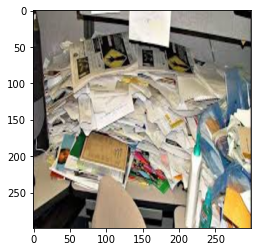

In [41]:
index = 4
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [42]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1] #1を０にした

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 33
Number of testing examples: m_test = 21
Height/Width of each image: num_px = 299
Each image is of size: (299, 299, 3)
train_set_x shape: (33, 299, 299, 3)
train_set_y shape: (1, 33)
test_set_x shape: (21, 299, 299, 3)
test_set_y shape: (1, 21)


In [43]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], num_px*num_px*3).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
# print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (268203, 33)
train_set_y shape: (1, 33)
test_set_x_flatten shape: (268203, 21)
test_set_y shape: (1, 21)


In [44]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.
print('number of train datasets =' + str(train_set_x.shape))
print('number of test datasets =' + str (test_set_x.shape))

number of train datasets =(268203, 33)
number of test datasets =(268203, 21)


In [45]:
print('% of Messy in the training data: ', 100*np.sum(train_set_y == 0)/len(train_set_y[0]))
print('% of Clean in the training data: ', 100*np.sum(train_set_y == 1)/len(train_set_y[0]))

% of Messy in the training data:  30.303030303030305
% of Clean in the training data:  69.6969696969697


In [46]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0.
    return w, b

def propagate(w, b, X, Y):
    m = X.shape[1]
    A = sigmoid(np.dot(w.T,X)+b)
    A = A.astype(np.float64)
    cost = -1/m*np.sum(np.nan_to_num(Y*np.log(A)+(1-Y)*np.log(1-A)),axis=1)  
    dw = 1/m*np.dot(X,(A-Y).T)
    db = 1/m*np.sum(A-Y)  
    cost = np.squeeze(np.array(cost))
    grads = {"dw": dw,
             "db": db}    
    return grads, cost

def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)  
    costs = []    
    for i in range(num_iterations): 
        grads, cost = propagate(w,b,X,Y)
        dw = grads["dw"]
        db = grads["db"]
        w = w-learning_rate*dw
        b = b-learning_rate*db 
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    params = {"w": w,
              "b": b}
    grads = {"dw": dw,
             "db": db}
    return params, grads, costs

def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T,X)+b)
    for i in range(A.shape[1]):
        if A[0,i]<=0.5:
            Y_prediction[0,i]=0
        else:
            Y_prediction[0,i]=1
    return Y_prediction

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    w, b = initialize_with_zeros(X_train.shape[0])
    parameters, grads, costs = optimize(w,b,X_train,Y_train,num_iterations,learning_rate,print_cost)
    w = parameters["w"]
    b = parameters["b"]
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    return d

In [47]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = 0.01, print_cost = True)

Cost after iteration 0: 0.693147


/var/folders/4x/x7rnt46j0q17b3kn7x6swf1r0000gn/T/ipykernel_37060/2381434555.py:14: RuntimeWarning: divide by zero encountered in log
  cost = -1/m*np.sum(np.nan_to_num(Y*np.log(A)+(1-Y)*np.log(1-A)),axis=1)
/var/folders/4x/x7rnt46j0q17b3kn7x6swf1r0000gn/T/ipykernel_37060/2381434555.py:14: RuntimeWarning: invalid value encountered in multiply
  cost = -1/m*np.sum(np.nan_to_num(Y*np.log(A)+(1-Y)*np.log(1-A)),axis=1)


Cost after iteration 100: 0.000017
Cost after iteration 200: 0.000008
Cost after iteration 300: 0.000005
Cost after iteration 400: 0.000004
Cost after iteration 500: 0.000003
Cost after iteration 600: 0.000003
Cost after iteration 700: 0.000002
Cost after iteration 800: 0.000002
Cost after iteration 900: 0.000002
Cost after iteration 1000: 0.000002
Cost after iteration 1100: 0.000001
Cost after iteration 1200: 0.000001
Cost after iteration 1300: 0.000001
Cost after iteration 1400: 0.000001
train accuracy: 100.0 %
test accuracy: 38.095238095238095 %


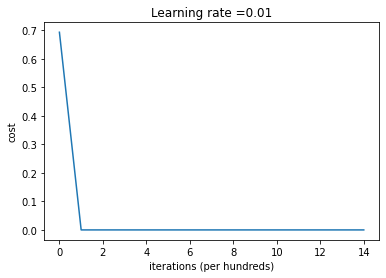

In [25]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

In [183]:
def ownimage(my_image):
    # We preprocess the image to fit your algorithm.
    fname = my_image
    image = np.array(Image.open(fname).resize((num_px, num_px)))
    plt.imshow(image)
    image = image / 255.
    image = image.reshape((1, num_px * num_px * 3)).T
    my_predicted_image = predict(d["w"], d["b"], image)

    print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

In [185]:
ownimage("/messy-vs-clean-room/images/test/0.png")

FileNotFoundError: [Errno 2] No such file or directory: '/messy-vs-clean-room/images/test/0.png'